# Analysis of Alert Notables from Splunk using CLX and RAPIDS

## Authors
 - Rachel Allen, PhD (NVIDIA)
 - Bianca Rhodes (NVIDIA)

## Development Notes
* Developed using: RAPIDS v0.10.0 and CLX v0.11
* Last tested using: RAPIDS v0.12.0 and CLX v0.12 on Feb 26, 2019

## Table of Contents
* Introduction
* Data Ingest
* Historical Trends
* Rolling Z-Scores for Anomaly Detection

## Introduction

To keep pace with cyber adversaries, organizations are constantly evolving in their approaches to information monitoring. With the addition of every new alert generated by ML models, heuristics, or sensors comes an additional data feed in need of triage and analysis. SOCs are frequently overwhelmed by the volume of alerts and unable to analyze a large portion of their data, resulting in potentially missed malicious activity. By leveraging the data processing and analytic capabilities of [RAPIDS](https://rapids.ai), a suite of open-source software libraries that allow for end-to-end data science pipelines in GPU memory, we demonstrate how it's possible to explore, analyze, and prioritize massive amounts of cyber data. 

## Imports

In [1]:
import pandas as pd
import numpy as np
import math
import itertools

# traditional viz
try:
    import clx 
except ImportError:
    !conda install -c rapidsai -y clx 
try:
    import s3fs 
except ImportError:
    !conda install -c conda-forge -y s3fs 

try:
    import seaborn as sns
except ImportError:
    !conda install -c conda-forge -y seaborn

from matplotlib import pyplot as plt
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, curdoc
from bokeh.themes import built_in_themes
from bokeh.layouts import column, gridplot
from bokeh.models import Span

# rapids io/df
import cudf
import dask_cudf

# rapids clx 
from clx.parsers.splunk_notable_parser import SplunkNotableParser
from clx import analytics
from clx.analytics.stats import rzscore

# rapids viz
from cuxfilter import charts, layouts, themes, DataFrame
from cuxfilter.charts import datashader, bokeh
import panel as pn

import s3fs
from os import path

## What are these libraries?

CLX (Cyber Log Accelerators) provides a simple API for security analysts, data scientists, and engineers to quickly get started applying RAPIDS to real-world cyber use cases. CLX uses the GPU dataframe ([cuDF](https://github.com/rapidsai/cudf)) and other RAPIDS packages to execute cybersecurity and information security workflows. The following packages are available:

* mlstats - Machine learning and statistics functionality
* ip - IPv4 data translation and parsing
* parsers - Cyber log event parsing
* io - Input and output features for a workflow
* workflow - Workflow which receives input data and produces analytical output data
* osi - Open source integration (VirusTotal, FarsightDB)
* dns - TLD, SLD extraction


## When to use [CLX](https://github.com/rapidsai/clx)

Use CLX to build your cyber data analytics workflows for a GPU-accelerated environmetn using RAPIDS. CLX contains common cyber and cyber ML functionality, such as log parsing for specific data sources, cyber data type parsing (e.g., IPv4), and DGA detection. CLX also provides the ability to integrate this functionality into a CLX workflow, which simplifies execution of the series of parsing and ML functions needed for end-to-end use cases.

# End-to-End Alert Analysis on GPU with CLX and RAPIDS

## Data Ingest with cuDF

In [2]:
if not path.exists("./splunk_faker_raw4"):
    fs = s3fs.S3FileSystem(anon=True)
    fs.get("rapidsai-data/cyber/clx/splunk_faker_raw4", "./splunk_faker_raw4")

In [3]:
%%time
# cuDF
gdf = cudf.read_csv('./splunk_faker_raw4')
gdf.columns = ['raw']

CPU times: user 1.06 s, sys: 2.03 s, total: 3.09 s
Wall time: 8.78 s


In [4]:
%%time
# pandas
pdf = pd.read_csv('./splunk_faker_raw4')
pdf.columns = ['raw']

CPU times: user 4.18 s, sys: 280 ms, total: 4.46 s
Wall time: 4.45 s


## Noteable Event Parsing from Splunk
CLX provides parsers to parse common log types including notable events indexed in Splunk.

In [5]:
from clx.parsers.splunk_notable_parser import SplunkNotableParser
snp = SplunkNotableParser()
parsed_gdf = cudf.DataFrame()

In [6]:
%%time
# clx
parsed_gdf = snp.parse(gdf, 'raw')

CPU times: user 2.39 s, sys: 1.22 s, total: 3.6 s
Wall time: 3.61 s


In [7]:
parsed_gdf.head(1)

time                                        search_name orig_time  \
2  1548814508  Threat - Source And Destination Matches - Thre...             

  urgency user owner security_domain severity        src_ip src_mac  ...  \
2                                              10.10.189.84          ...   

  dest_port dest_priority device_name event_name event_type ip_address  \
2                                                                        

  message_ip message_hostname message_username message_description  
2                                                                   

[1 rows x 23 columns]

In [8]:
%%time
# pandas

pdf['time'] = pdf['raw'].str.extract('(^[0-9]+\.?[0-9]*),')
pdf['search_name'] = pdf['raw'].str.extract('search_name=\"([0-9A-Za-z\s\-\(\)]+)')
pdf['urgency'] = pdf['raw'].str.extract('urgency=\"([A-Za-z]+)')
pdf['user'] = pdf['raw'].str.extract('user=\"([A-Za-z0-9]+)')
pdf['owner'] = pdf['raw'].str.extract('owner=\"([\w@\.]+)')
pdf['security_domain'] = pdf['raw'].str.extract('security_domain=\"([A-Za-z]+)')
pdf['severity'] = pdf['raw'].str.extract('severity=\"([A-Za-z]+)')
pdf['src_ip'] = pdf['raw'].str.extract('src_ip=\"([\w\.\-]+)')
pdf['src_mac'] = pdf['raw'].str.extract('smac=([\w\:]+)')
pdf['src_port'] = pdf['raw'].str.extract('src_port=\"(\d+)')
pdf['dest_ip'] = pdf['raw'].str.extract('dest_ip=\"([\w\.\-]+)')
pdf['dest_mac'] = pdf['raw'].str.extract('dmac=([\w\:]+)')
pdf['dest_port'] = pdf['raw'].str.extract('dest_port=\"(\d+)')
pdf['dest_priority'] = pdf['raw'].str.extract('dest_priority="([A-Za-z]+)')
pdf['device_name'] = pdf['raw'].str.extract('Device Name:\s([0-9A-Za-z\_\-]+)')
pdf['event_name'] = pdf['raw'].str.extract('Event Name:\s([A-Za-z\_]+)')
pdf['event_type'] = pdf['raw'].str.extract('Event Type:\s([A-Za-z]+)')
pdf['ip_address'] = pdf['raw'].str.extract('IP Address:\s\(([0-9\.]+)')
pdf['message_ip'] = pdf['raw'].str.extract('message.ip="([\w\.]+)')
pdf['message_hostname'] = pdf['raw'].str.extract('message.hostname="([\w\.]+)')
pdf['message_username'] = pdf['raw'].str.extract('message.user_name="([\w\.\@]+)')
pdf['message_description'] = pdf['raw'].str.extract('message\.description="([\w\.\s]+)')

CPU times: user 1min, sys: 1.56 s, total: 1min 2s
Wall time: 1min 2s


## Using RAPIDS for fast ETL and `groupby` operations

In [9]:
# add 2 functions - time rounded to day, time rounded to hour
def round2day(epoch_time):
    return int(epoch_time/86400)*86400

def round2hour(epoch_time):
    return int(epoch_time/3600)*3600  

In [10]:
%%time
# cuDF

parsed_gdf['time'] = parsed_gdf['time'].astype(int)

parsed_gdf['day'] = parsed_gdf.time.applymap(round2day)
parsed_gdf['hour'] = parsed_gdf.time.applymap(round2hour)

# aggregated by hour
hour_rule_gdf= parsed_gdf[['search_name','hour','time']].groupby(['search_name', 'hour']).count().reset_index()
hour_rule_gdf.columns = ['rule', 'hour', 'count']

# aggregated by day
day_rule_gdf= parsed_gdf[['search_name','day','time']].groupby(['search_name', 'day']).count().reset_index()
day_rule_gdf.columns = ['rule', 'day', 'count']

CPU times: user 177 ms, sys: 56.7 ms, total: 234 ms
Wall time: 239 ms


In [11]:
%%time
# pandas

pdf['time'] = pdf['time'].astype(int)

pdf['day'] = pdf.time.apply(round2day)
pdf['hour'] = pdf.time.apply(round2hour)

# aggregated by hour
hour_rule_pdf= pdf[['search_name','hour','time']].groupby(['search_name', 'hour']).count().reset_index()
hour_rule_pdf.columns = ['rule', 'hour', 'count']

# aggregated by day
day_rule_pdf= pdf[['search_name','day','time']].groupby(['search_name', 'day']).count().reset_index()
day_rule_pdf.columns = ['rule', 'day', 'count']

CPU times: user 8.16 s, sys: 1.05 s, total: 9.21 s
Wall time: 9.2 s


## Heatmap Visualization

Create a heatmap of normalized alert counts by day using cuXfilter or seaborn.

In [12]:
# normalize counts and convert strings

def normalize_gdf(input_gdf, time_gdf):
    """ normalize event counts in DataFrame by rule
        :input_gdf: cudf DataFrame with 'rule' column
        :time_gdf: cudf with a column for times at each interval, so there is an entry for every day or hour even if it's 0
    """

    rules_gdf = input_gdf['rule'].unique()
    for num in range(len(rules_gdf)):
        rule = rules_gdf[num]
        temp_df = cudf.DataFrame()
        temp_df = input_gdf[input_gdf['rule'] == rule]
        temp_df = time_gdf.merge(temp_df, how='left')
        temp_df['count'] = temp_df['count'].fillna(0)
        temp_df['normalized'] = (temp_df['count'] - temp_df['count'].mean())/ temp_df['count'].std()
        temp_df['rule_num'] = num
        temp_df['rule'] = rule
        if num == 0:
            output_df = temp_df
        else:
            output_df = cudf.concat([output_df, temp_df])
    return output_df

# create one dataframe for alerts grouped by hour, one for alerts grouped by day

hours_gdf = cudf.DataFrame()
hours_gdf['hour'] = list(range(hour_rule_gdf['hour'].min(), hour_rule_gdf['hour'].max(), 3600))

hours_viz_df = normalize_gdf(hour_rule_gdf, hours_gdf)
hours_viz_df['count'] = hours_viz_df['count'].astype(float)
hours_viz_df['rule_num'] = hours_viz_df['rule_num'].astype(float)
hours_viz_df['hour'] = hours_viz_df['hour'].astype(float)

day_gdf = cudf.DataFrame()
day_gdf['day'] = list(range(day_rule_gdf['day'].min(), day_rule_gdf['day'].max(), 86400))

days_viz_df = normalize_gdf(day_rule_gdf, day_gdf)
days_viz_df['count'] = days_viz_df['count'].astype(float)
days_viz_df['rule_num'] = days_viz_df['rule_num'].astype(float)
days_viz_df['day'] = days_viz_df['day'].astype(float)

### cuXfilter

[cuXfilter](https://github.com/rapidsai/cuxfilter) ( ku-cross-filter ) is a RAPIDS framework to connect web visualizations to GPU accelerated crossfiltering. Inspired by the javascript version of the original, it enables interactive and super fast multi-dimensional filtering of 100 million+ row tabular datasets via cuDF.

In [13]:
# for in notebook viz
pn.extension()

In [14]:
cux_df = DataFrame.from_dataframe(hours_viz_df)
chart1 = charts.datashader.heatmap(x='hour', y='rule_num', aggregate_col='normalized', point_size = 30, title = 'Alerts Per Hour By Type')
d = cux_df.dashboard([chart1], layout=layouts.single_feature)
chart1.view()

Card(sizing_mode='stretch_both', title='Alerts Per Hour By Type', width=800)
    [0] Bokeh(Figure)

In [15]:
cux_df = DataFrame.from_dataframe(days_viz_df)
chart2 = charts.datashader.heatmap(x='day', y='rule_num', aggregate_col='normalized', point_size = 30, title = 'Alerts Per Day By Type')
d = cux_df.dashboard([chart2], layout=layouts.single_feature)
chart2.view()

Card(sizing_mode='stretch_both', title='Alerts Per Day By Type', width=800)
    [0] Bokeh(Figure)

### matplotlib visualization

In [16]:
day_rule_pdf['day'] = pd.to_datetime(day_rule_pdf['day'], unit = 's').dt.strftime('%Y-%m-%d')
day_rule_pdf = day_rule_pdf.pivot(index='day', columns='rule', values='count').fillna(0)
normalized_df=(day_rule_pdf-day_rule_pdf.mean())/day_rule_pdf.std()

<AxesSubplot:xlabel='rule', ylabel='day'>

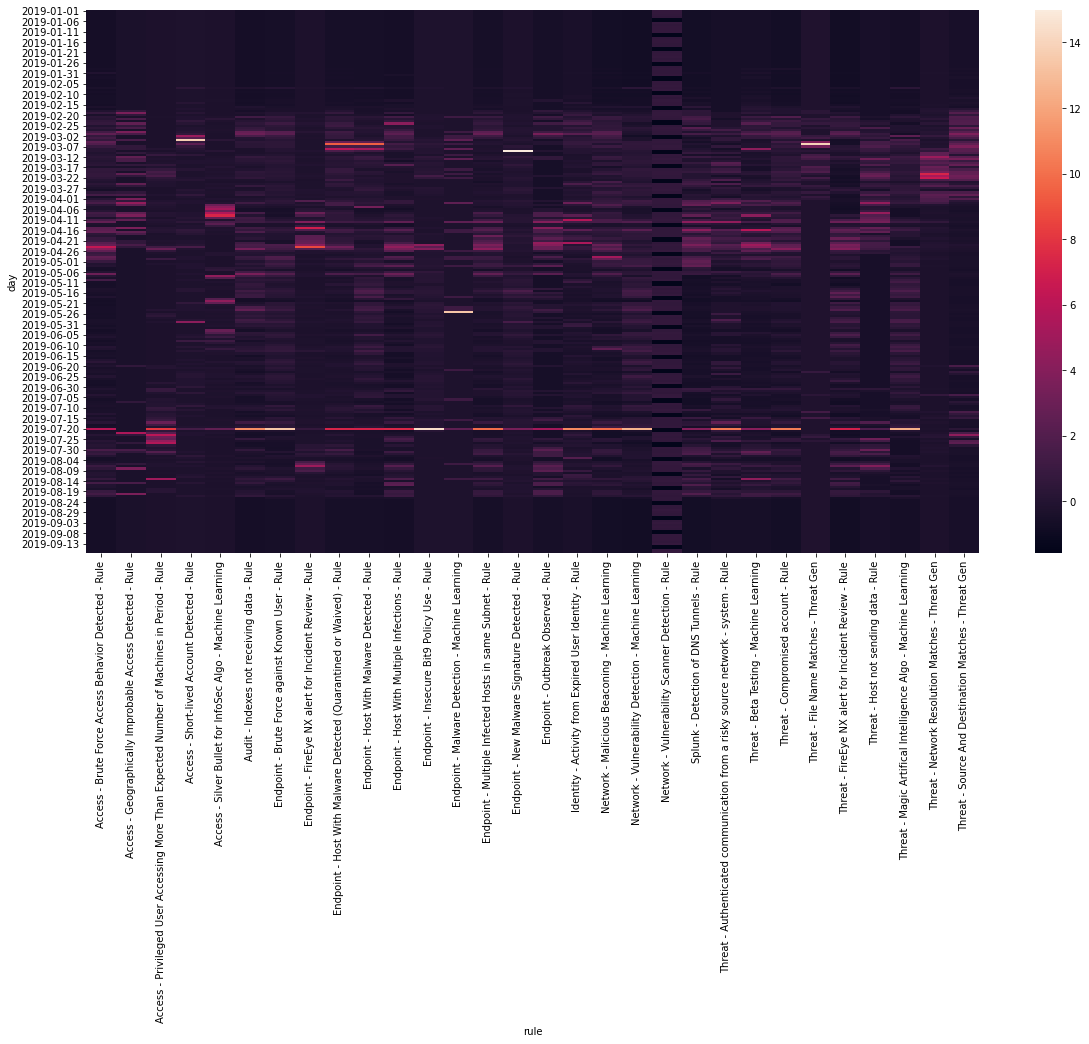

In [17]:
plt.figure(figsize=(20,10))
sns.heatmap(normalized_df)

## Rolling Z-Score with CLX `stats` Module
Detect large changes in the volume of specific alerts over time

In [18]:
from clx.analytics.stats import rzscore

In [19]:
# pivot the alert data so each rule is a column

def pivot_table(gdf, index_col, piv_col, v_col):
    """ Create a spreadsheet-style pivot table as a DataFrame
    
        :gdf: cudf DataFrame
        :ind ex_col: keys to group by on the pivot table index
        :piv_col: keys to group by on the pivot table column
        :v_col: column to aggregrate
    """
    index_list = gdf[index_col].unique()
    piv_gdf = cudf.DataFrame()
    piv_gdf[index_col] = index_list
    groups_gdf = gdf[piv_col].unique()
    for i in range(len(groups_gdf)):
        group = groups_gdf[i]
        temp_df = gdf[gdf[piv_col] == group]
        temp_df = temp_df[[index_col, v_col]]
        temp_df.columns = [index_col, group]
        piv_gdf = piv_gdf.merge(temp_df, on=[index_col], how='left')
    piv_gdf = piv_gdf.set_index(index_col)
    return piv_gdf.sort_index()

alerts_per_day_piv = pivot_table(day_rule_gdf, 'day', 'rule', 'count').fillna(0)

In [20]:
#create a new df with rolling zscores

r_zscores = cudf.DataFrame()
for rule in alerts_per_day_piv.columns:
    x = alerts_per_day_piv[rule]
    r_zscores[rule] = rzscore(x, 7) #7 day window

## Line charts highlighting anomalous rule frequencies

### cuXfilter

In [21]:
column_name = 'Access - Brute Force Access Behavior Detected - Rule'
temp_df = cudf.DataFrame()
temp_df['rule'] = alerts_per_day_piv[column_name]
temp_df['day'] = temp_df.index

        
cux_df = DataFrame.from_dataframe(temp_df)
chart3 = datashader.line('day', 'rule')

d = cux_df.dashboard([chart3])

chart3.view()

Card(sizing_mode='stretch_both', title='Line plot for (day,r..., width=800)
    [0] Bokeh(Figure)
    [1] RangeSlider(end=1568678400, sizing_mode='scale_width', start=1546300800, step=223776, value=(1546300800, 1568678400), value_throttled=(1546300800, 1568678400), width=800)

### bokeh charts

In [22]:
from bokeh.palettes import Dark2_5 as palette

def anomaly_plot_bokeh(ts_df, zc_df):
    """ Makes on chart for every column, adds red lines for timepoints that pass zscore threshold
        :ts_df: timeseries DataFrame
        :zc_df: rolling z score DataFrame
    """
    colors = itertools.cycle(palette)     # create a color iterator
    for column, color in zip(ts_df.columns.tolist(), colors):
        p = figure(x_axis_type="datetime", plot_width=1000, plot_height=100, title=column)
        p.line(ts_df.index, ts_df[column], color=color, line_width = 2 )
        p.title.text_font_size = '8pt'
        p.xaxis.major_label_text_font_size = "8pt"
        p.yaxis.major_label_text_font_size = "8pt"
        p.xgrid.visible = False
        xcoords = zc_df[column].loc[(zc_df[column]).abs() > 2.2].index.values
        for xc in xcoords:
            vert_line = Span(location=xc, dimension='height', line_color='red', line_width=3, line_alpha=0.5)
            p.add_layout(vert_line)
        show(p)

In [23]:
# moving back to pandas for bokeh
alerts_piv_pdf = alerts_per_day_piv.to_pandas()
alerts_piv_pdf.index = pd.to_datetime(alerts_piv_pdf.index, unit = 's')
r_zscores_pdf = r_zscores.to_pandas()
r_zscores_pdf.index = pd.to_datetime(r_zscores_pdf.index, unit = 's')

In [24]:
# chart first 10 rules with anamoly highlights
output_notebook()
anomaly_plot_bokeh(alerts_piv_pdf.iloc[:,range(10)], r_zscores_pdf.iloc[:,range(10)])

Loading BokehJS ...

## Conclusion

The ability to visualize trends and highlight abnormalities in splunk alerts empowers cyber analysts to get more from the data they are already collecting. Instead of relying on individuals to keep a mental note of alert trends and co-occurences, CLX can keep up with the high velocity of data and highlight potentially overlooked alerts in need of analysis. 